# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [24]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import graphviz
from datetime import date
import time
import pyreadr

import os
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchviz import make_dot

import math

print(torch.__version__) # 1.9.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.9.1+cu111
cuda


# Load data

In [27]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)
scaler_MG = MinMaxScaler(feature_range = (0, 1)).fit(MG)
MG = scaler_MG.transform(MG)
tileMG = np.tile(MG, 214)

# Transform Genotype into ClusterID, and stack with MG
# Genotype = df_train['Genotype'].astype('category')
# Genotype = Genotype.to_numpy()
# K = np.empty(len(Genotype))
# for i in range(len(ClusterID)):
#     K[Genotype==i] = ClusterID[i]
# K = K.reshape(-1,1)
# MG = np.hstack([MG, K])

# Standardization prcess
scaler_x0 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,1])
scaled_x1 = scaler_x1.transform(Weather_train[:,:,1])
scaler_x2 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,2])
scaled_x2 = scaler_x2.transform(Weather_train[:,:,2])
scaler_x3 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,3])
scaled_x3 = scaler_x3.transform(Weather_train[:,:,3])
scaler_x4 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,4])
scaled_x4 = scaler_x4.transform(Weather_train[:,:,4])
scaler_x5 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,5])
scaled_x5 = scaler_x5.transform(Weather_train[:,:,5])
scaler_x6 = MinMaxScaler(feature_range = (0, 1)).fit(Weather_train[:,:,6])
scaled_x6 = scaler_x6.transform(Weather_train[:,:,6])
# X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6, tileMG])

Y = Y.reshape(-1,1)
scaler_Y = MinMaxScaler(feature_range = (0, 1)).fit(Y)
Y = scaler_Y.transform(Y)

# Trancation
X = X[:,np.arange(0,214,7),:] 

#####################################
# Load training and validation data #
#####################################
# 10% is test, 10% is val, 80% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.8, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.8, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

MG_train, MG_val = train_test_split(MG, test_size=0.8, shuffle=True, random_state=888)
MG_val, MG_test = train_test_split(MG_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''

# Transform into tensor
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

Y_train = Y_train.view(-1,1)
Y_val = Y_val.view(-1,1)
Y_test = Y_test.view(-1,1)


MG_train = MG_train.astype('float')
MG_val = MG_val.astype('float')
MG_test = MG_test.astype('float')

MG_train = torch.from_numpy(MG_train).int()
MG_val = torch.from_numpy(MG_val).int()
MG_test = torch.from_numpy(MG_test).int()

In [49]:
# Export train data as csv
inputs_others_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

np.savetxt('./Dataset_Competition/Training/inputs_others_train.csv', inputs_others_train, delimiter=',', fmt='%s')
np.savetxt('./Dataset_Competition/Training/yield_train.csv', Y, delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_1.csv', Weather_train[:,:,0], delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_2.csv', Weather_train[:,:,1], delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_3.csv', Weather_train[:,:,2], delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_4.csv', Weather_train[:,:,3], delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_5.csv', Weather_train[:,:,4], delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_6.csv', Weather_train[:,:,5], delimiter=',')
np.savetxt('./Dataset_Competition/Training/inputs_weather_train_7.csv', Weather_train[:,:,6], delimiter=',')
np.savetxt('./Dataset_Competition/clusterID_genotype.csv', ClusterID, delimiter=',')

In [50]:
# Export test data as csv
inputs_others_test = np.load('./Dataset_Competition/Test Inputs/inputs_others_test.npy')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_others_test.csv', inputs_others_test, delimiter=',', fmt='%s')

Weather_test = np.load('./Dataset_Competition/Test Inputs/inputs_weather_test.npy')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_1.csv', Weather_test[:,:,0], delimiter=',')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_2.csv', Weather_test[:,:,1], delimiter=',')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_3.csv', Weather_test[:,:,2], delimiter=',')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_4.csv', Weather_test[:,:,3], delimiter=',')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_5.csv', Weather_test[:,:,4], delimiter=',')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_6.csv', Weather_test[:,:,5], delimiter=',')
np.savetxt('./Dataset_Competition/Test Inputs/inputs_weather_test_7.csv', Weather_test[:,:,6], delimiter=',')

In [31]:
Weather_train.shape

(93028, 214, 7)

In [32]:
# Check the sample size for each state
# df = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
# tab = df.groupby(['State']).size()
# tab

# LSTM
X (weather data) is not treated as indepedent inputs

# Define function

In [20]:
# Prediction function
def batch_pred(X,MG):
    global x
    pred_list = []
    batch_size = 512
    x = 0
    for i in range(math.ceil(X.shape[0]/batch_size)):
        with torch.no_grad():
            temp_X = X[x:x+batch_size].to(device)
            temp_MG = MG[x:x+batch_size].to(device)

            pred = model(temp_X,temp_MG).detach().cpu().numpy().astype('float').tolist()
        pred_list.extend(pred)
        x = x + batch_size
    return pred_list

# Model Architecture (LSTM)

In [21]:
# Stacked LSTM

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, con_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.con_dim = con_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=0.2, batch_first=True) # hs = {32, 64, 96, 128, 256}
        self.fc = nn.Linear(hidden_dim, con_dim) # con_dim =(1, 2, 4, 8, 16) # Reduction in dimension of the temporal context to con_dim before concat with MG, Cluster
        self.relu = nn.ReLU()
        self.regressor = nn.Linear(con_dim+1, 1) # con_dim, MG, CusterID
        
    def forward(self, X, MG):
        whole_sequence_output, (h_T, c_T) = self.lstm(X)
        lstm_out = whole_sequence_output[:,-1,:] # `return_sequences = False` equivalent in pytorch LSTM
#         lstm_out = h_T[num_layers-1,:,:] # `return_sequences = False` equivalent in pytorch LSTM?
        fc = self.fc(lstm_out)
        fc = self.relu(fc)
        
        cat = torch.cat((fc,MG), dim=1) # dim=0
        pred = self.regressor(cat)
        return pred

In [64]:
# Two LSTMs were independently defined
# This does not work well

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, con_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.con_dim = con_dim
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=0.2, batch_first=True) # hs = {32, 64, 96, 128, 256}\
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, con_dim) # con_dim =(1, 2, 4, 8, 16) # Reduction in dimension of the temporal context to con_dim before concat with MG, Cluster
        self.relu = nn.ReLU()
        self.regressor = nn.Linear(con_dim+1, 1) # con_dim, MG, CusterID
        
    def forward(self, X, MG):
        whole_sequence_output, (h_T, c_T) = self.lstm1(X, None) # None is an initial hidden state and cell.
#         out = out[:,-1,:] # `return_sequences = False` equivalent in pytorch LSTM
#         lstm_out = h_T[0,:,:] # the value should be changed according to 'num_layers'
        whole_sequence_output, (h_T, c_T) = self.lstm2(whole_sequence_output)
        lstm_out = h_T[0,:,:]
        fc = self.fc(lstm_out)
        fc = self.relu(fc)
        
        cat = torch.cat((fc,MG), dim=1) # dim=0
        pred = self.regressor(cat)
        return pred

In [29]:
# For Checking dimension
batch_size = 10
X = torch.randn(batch_size, 214, 7)
MG = torch.randn(batch_size, 2)
print(X.shape)

lstm = nn.LSTM(7,128,num_layers = 2, dropout=0.2, batch_first=True)
fc1 = nn.Linear(128,2)
relu = nn.ReLU()

hidden = (torch.randn(2,batch_size,128), torch.randn(2,batch_size,128))

whole_sequence_output, (h_T, c_T) = lstm(X,hidden)

print('whole_sequence_output: ', whole_sequence_output.shape)
print('ht: ',h_T.shape) # ht
print('Ct: ',c_T.shape) # Ct

# out = out[:,-1,:] # `return_sequences = False` equivalent in pytorch LSTM
# out = out.view(-1)
lstm_out = h_T[1,:,:]
print(lstm_out.shape)

fc = fc1(lstm_out)
fc = relu(fc) 

print(fc.shape)

# Note that out[:,-1,:] and state[0][1] are the same?
print(lstm_out)

cat = torch.cat((fc,MG), dim=1)
print(cat.shape)

torch.Size([10, 214, 7])
whole_sequence_output:  torch.Size([10, 214, 128])
ht:  torch.Size([2, 10, 128])
Ct:  torch.Size([2, 10, 128])
torch.Size([10, 128])
torch.Size([10, 2])
tensor([[ 0.0206,  0.0323,  0.0245,  ..., -0.0070,  0.0033,  0.0257],
        [ 0.0128,  0.0131,  0.0145,  ..., -0.0215,  0.0120,  0.0220],
        [ 0.0270,  0.0148,  0.0163,  ..., -0.0060,  0.0041, -0.0008],
        ...,
        [ 0.0214,  0.0135,  0.0336,  ..., -0.0043,  0.0122,  0.0194],
        [ 0.0234,  0.0003,  0.0031,  ..., -0.0030,  0.0270,  0.0209],
        [ 0.0205,  0.0283,  0.0242,  ..., -0.0182, -0.0059,  0.0065]],
       grad_fn=<SliceBackward>)
torch.Size([10, 4])


In [30]:
# For Checking dimension
batch_size = 10
X = torch.randn(batch_size, 214, 7)
MG = torch.randn(batch_size, 2)
print(X.shape)

# lstm = nn.LSTM(7,128,num_layers = 2, dropout=0.2, batch_first=True)
lstm1 = nn.LSTM(7,128,num_layers = 1, batch_first=True)
lstm2 = nn.LSTM(128,128,num_layers = 1, batch_first=True)
fc1 = nn.Linear(128,2)
relu = nn.ReLU()

whole_sequence_output, (h_T, c_T) = lstm1(X)

print('whole_sequence_output: ', whole_sequence_output.shape)
print('ht: ',h_T.shape) # ht
print('Ct: ',c_T.shape) # Ct

# out = out[:,-1,:] # `return_sequences = False` equivalent in pytorch LSTM
# out = out.view(-1)
lstm_out = h_T.reshape(10,1,128)
print(lstm_out.shape)

whole_sequence_output, (h_T, c_T) = lstm2(lstm_out)

print('whole_sequence_output: ', whole_sequence_output.shape)
print('ht: ',h_T.shape) # ht
print('Ct: ',c_T.shape) # Ct

lstm_out = h_T[0,:,:]
print(lstm_out.shape)

fc = fc1(lstm_out)
fc = relu(fc) 

print(fc.shape)

# Note that out[:,-1,:] and state[0][1] are the same? ACTUALLy not the same!!!the final hidden layer 
print(lstm_out)
print(MG.shape)

cat = torch.cat((fc,MG), dim=1)
print(cat.shape)

torch.Size([10, 214, 7])
whole_sequence_output:  torch.Size([10, 214, 128])
ht:  torch.Size([1, 10, 128])
Ct:  torch.Size([1, 10, 128])
torch.Size([10, 1, 128])
whole_sequence_output:  torch.Size([10, 1, 128])
ht:  torch.Size([1, 10, 128])
Ct:  torch.Size([1, 10, 128])
torch.Size([10, 128])
torch.Size([10, 2])
tensor([[ 0.0272,  0.0047,  0.0213,  ...,  0.0073, -0.0084, -0.0123],
        [ 0.0261, -0.0033,  0.0174,  ...,  0.0041, -0.0059, -0.0239],
        [ 0.0255,  0.0008,  0.0266,  ...,  0.0098, -0.0098, -0.0268],
        ...,
        [ 0.0248, -0.0095,  0.0162,  ...,  0.0138,  0.0072, -0.0073],
        [ 0.0273, -0.0073,  0.0140,  ...,  0.0078, -0.0024, -0.0140],
        [ 0.0321, -0.0079,  0.0090,  ...,  0.0023, -0.0010, -0.0241]],
       grad_fn=<SliceBackward>)
torch.Size([10, 2])
torch.Size([10, 4])


# Visualiza model architechture

In [14]:
# Visualize model architecture
batch_size = 1
X = torch.randn(batch_size, 214, 8)# .to(device) # batch size, time steps, vaiable_n: 214, 107
MG = torch.randn(batch_size, 1) #.to(device) # MG and ClusterID

model = LSTM(8,128,2,2) 
# model.to(device)
# summary(model,input_size=([1,214,7],[1,1]))
print(model)

# Visualize the architecture using make_dot
# model2 = LSTM()
# yDummy = model2(X, MG)
# make_dot(yDummy, params=dict(model.named_parameters()))

# Visualize the architecture using Netron
dummy_input = X,MG
# model.to(device)
torch.onnx.export(model, dummy_input,'./lstm.onnx', input_names=['X','MG'], output_names='y')

LSTM(
  (lstm): LSTM(8, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (regressor): Linear(in_features=3, out_features=1, bias=True)
)


c:\users\takashi tanaka\venv2\lib\site-packages\torch\onnx\symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


## Train process

In [22]:
#################
# Train process #
#################

input_dim = 8
hidden_dim = 128
num_layers = 2
con_dim = 2

model = LSTM(input_dim, hidden_dim, num_layers,con_dim)
model.to(device)

counter = 0 # For earlystop

PATIENCE = 10
EPOCH = 10000 # 500
BATCH_SIZE = 1024

losses = []
torch.manual_seed(123)    # reproducible

loss_func = nn.MSELoss()
# optimizer = optimizers.Adam(model.parameters(), lr=0.001)#default is 0.001
optimizer = optimizers.SGD(model.parameters(), lr=0.01)#default is 0.01

# Dataloader
train_len = X_train.size()[0]
val_len = X_val.size()[0]
test_len = X_test.size()[0]

X = X_train
Y = Y_train
MG = MG_train
trainset = torch.utils.data.TensorDataset(X, MG, Y)
X = X_val
Y = Y_val
MG = MG_val
valset = torch.utils.data.TensorDataset(X, MG, Y)
X = X_test
Y = Y_test
MG = MG_test
testset = torch.utils.data.TensorDataset(X, MG, Y)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
data_loaders = {"train": train_loader, "val": validation_loader, "test":test_loader}
data_lengths = {"train": train_len, "val": val_len, "test": test_len}

losses_train = []
losses_val = []
losses_test = []

for epoch in range(EPOCH):
    print('Epoch {}/{}'.format(epoch + 1, EPOCH))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val', 'test']:
        if phase == 'train':
            #optimizer = scheduler(optimizer, epoch)
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:

            # get the input images and their corresponding labels
            X, MG, Y = data

            # flatten pts
            #key_pts = key_pts.view(key_pts.size(0), -1)

            # wrap them in a torch Variable
            X, MG, Y = Variable(X), Variable(MG), Variable(Y)

            # convert variables to floats for regression loss
            Y = Y.type(torch.cuda.FloatTensor)
            X = X.type(torch.cuda.FloatTensor)
            MG = MG.type(torch.cuda.FloatTensor)
            
            # forward pass to get outputs
#             outputs = model(X,MG)
            outputs = model(X,MG)
    
            # calculate the loss between predicted and target keypoints
            loss = loss_func(outputs, Y)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.data.item() #[0]

        epoch_loss = running_loss / data_lengths[phase]

        if phase == 'train':
            losses_train.append(epoch_loss)
        elif phase =='val':
            losses_val.append(epoch_loss)
            # Earlystopping
            if epoch == 0:
                best_score = epoch_loss
            else:
                best_score = min(losses_val)
                if losses_val[-1] > best_score:
                    counter += 1
                elif losses_val[-1] == best_score:
                    counter = 0
                    filepath = './model/LSTM_BestModel.pth'
                    torch.save(model.state_dict(), filepath) # save the best-score model
        else:
            losses_test.append(epoch_loss)
                    
        if phase == 'train':
            print('{} Loss: {:.8f}'.format(phase, epoch_loss))
        elif phase == 'val':
            print('{} Loss: {:.8f}'.format(phase, epoch_loss))
            print('Counter: {}'.format(counter))
            print('-' * 10)

    # Earlystopping
    if counter == PATIENCE:
        print("Early Stopping!")
        print('---Training completed at the {}th epoch'.format(epoch+1))
        break

Epoch 1/10000
train Loss: 0.00034612
val Loss: 0.00020098
Counter: 0
----------
Epoch 2/10000
train Loss: 0.00014295
val Loss: 0.00008711
Counter: 0
----------
Epoch 3/10000
train Loss: 0.00006590
val Loss: 0.00004483
Counter: 0
----------
Epoch 4/10000
train Loss: 0.00003788
val Loss: 0.00003016
Counter: 0
----------
Epoch 5/10000
train Loss: 0.00002839
val Loss: 0.00002511
Counter: 0
----------
Epoch 6/10000
train Loss: 0.00002498
val Loss: 0.00002352
Counter: 0
----------
Epoch 7/10000
train Loss: 0.00002383
val Loss: 0.00002309
Counter: 0
----------
Epoch 8/10000
train Loss: 0.00002347
val Loss: 0.00002273
Counter: 0
----------
Epoch 9/10000
train Loss: 0.00002324
val Loss: 0.00002260
Counter: 0
----------
Epoch 10/10000
train Loss: 0.00002325
val Loss: 0.00002263
Counter: 1
----------
Epoch 11/10000
train Loss: 0.00002296
val Loss: 0.00002250
Counter: 0
----------
Epoch 12/10000
train Loss: 0.00002288
val Loss: 0.00002246
Counter: 0
----------
Epoch 13/10000
train Loss: 0.00002283

val Loss: 0.00002039
Counter: 1
----------
Epoch 103/10000
train Loss: 0.00002095
val Loss: 0.00002035
Counter: 2
----------
Epoch 104/10000
train Loss: 0.00002092
val Loss: 0.00002037
Counter: 3
----------
Epoch 105/10000
train Loss: 0.00002083
val Loss: 0.00002031
Counter: 0
----------
Epoch 106/10000
train Loss: 0.00002075
val Loss: 0.00002034
Counter: 1
----------
Epoch 107/10000
train Loss: 0.00002081
val Loss: 0.00002030
Counter: 0
----------
Epoch 108/10000
train Loss: 0.00002093
val Loss: 0.00002032
Counter: 1
----------
Epoch 109/10000
train Loss: 0.00002077
val Loss: 0.00002028
Counter: 0
----------
Epoch 110/10000
train Loss: 0.00002077
val Loss: 0.00002027
Counter: 0
----------
Epoch 111/10000
train Loss: 0.00002093
val Loss: 0.00002028
Counter: 1
----------
Epoch 112/10000
train Loss: 0.00002090
val Loss: 0.00002030
Counter: 2
----------
Epoch 113/10000
train Loss: 0.00002085
val Loss: 0.00002030
Counter: 3
----------
Epoch 114/10000
train Loss: 0.00002076
val Loss: 0.0000

# Check the best model

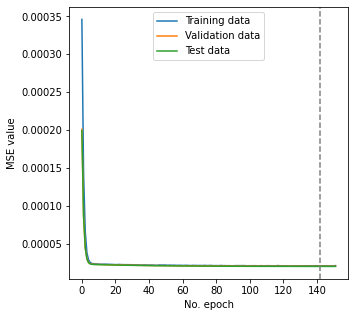

Train


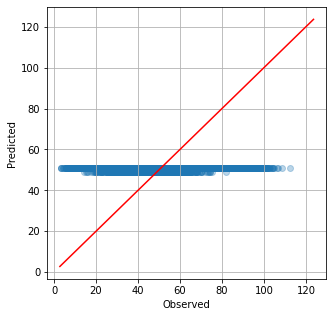

Validation


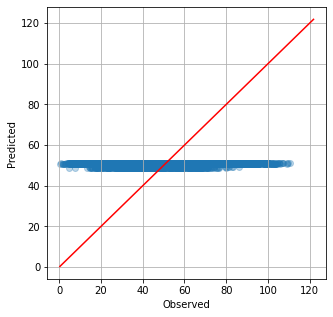

Test


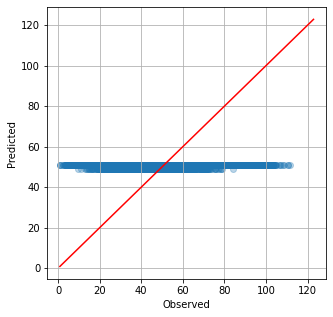

Train RMSE: 15.97
Train MAE: 12.78
Train R2: 0.003
Validation RMSE: 15.96
Validation MAE: 12.77
Validation R2: 0.004
Test RMSE: 15.87
Test MAE: 12.69
Test R2: 0.003


In [23]:
# Loss function
plt.figure(figsize=(5,5))
plt.plot(losses_train,label='Training data') 
plt.plot(losses_val,label='Validation data') 
plt.plot(losses_test,label='Test data') 

plt.axvline(x=epoch+1-PATIENCE, ls='--', color='grey')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend()
# plt.ylim([0,1])
plt.show()

# Prediction
# Resnet is required to be put in evaluation mode in order 
# to do prediction / evaluation
model = LSTM(input_dim, hidden_dim, num_layers, con_dim)
model.to(device)
filepath = './model/LSTM_BestModel.pth'
model.load_state_dict(torch.load(filepath))
model.eval()

pred_train = batch_pred(X_train,MG_train)
pred_val = batch_pred(X_val,MG_val)
pred_test = batch_pred(X_test,MG_test)

# Inverse transform
pred_train = scaler_Y.inverse_transform(pred_train)
pred_val = scaler_Y.inverse_transform(pred_val)
pred_test = scaler_Y.inverse_transform(pred_test)

inv_Y_train = scaler_Y.inverse_transform(Y_train.cpu().numpy())
inv_Y_val = scaler_Y.inverse_transform(Y_val.cpu().numpy())
inv_Y_test = scaler_Y.inverse_transform(Y_test.cpu().numpy())
            
# Plotting model results
print("Train")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_train, pred_train, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_train).item(), 1.1*max(inv_Y_train).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Validation")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_val, pred_val, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_val).item(), 1.1*max(inv_Y_val).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test")
plt.figure(figsize=(5,5))
plt.scatter(inv_Y_test, pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(inv_Y_test).item(), 1.1*max(inv_Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Train RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_train, pred_train))))
print("Train MAE: %.2f" % (mean_absolute_error(inv_Y_train, pred_train)))
print("Train R2: %.3f" % (r2_score(inv_Y_train, pred_train)))

print("Validation RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_val, pred_val))))
print("Validation MAE: %.2f" % (mean_absolute_error(inv_Y_val, pred_val)))
print("Validation R2: %.3f" % (r2_score(inv_Y_val, pred_val)))

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(inv_Y_test, pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(inv_Y_test, pred_test)))
print("Test R2: %.3f" % (r2_score(inv_Y_test, pred_test)))

# 1. Model perfomance from the original paper
## Including All & Temporal Attention
- RMSE = 7.226
- MAE = 5.441
- Rsq = 0.795

## Including All & SVR-RBF
- RMSE = 7.875
- MAE = 5.976
- Rsq = 0.758

# 2. MLYakuza scores

Note that we don't have actual test dataset. So it's impossible to compare the score values with the original paper.

## LF-CNN without ClusterID 1st trial (Sep 24, 2021)
- RMSE = 8.26
- MAE = 6.31
- Rsq = 0.730

## LF-CNN without ClusterID 2nd trial (Sep 30, 2021)
Multiple 1D CNN layers are used.
- RMSE: 8.67
- MAE: 6.65
- R2: 0.702

## Random Forest without ClusterID 1st trial (Sep 27, 2021)
- RMSE = 7.51
- MAE = 5.67
- Rsq = 0.777

## Random Forest with ClusterID (Sep 28, 2021)
- RMSE = 8.02
- MAE = 6.01
- Rsq = 0.745

### Result: RF does not need ClusterID information

## Lasso without ClusterID (Sep 29, 2021)
- RMSE: 8.29
- MAE: 6.24
- R2: 0.728


## Lasso with ClusterID (Sep 29, 2021)
- RMSE: 8.29
- MAE: 6.24
- R2: 0.728

## XGboost
